# Time Series

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

In [2]:
data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)
print(data.index.is_monotonic)
data.info()
data.head()

True
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


The time series contains 2 columns with 26496 entries each, with no missing values. 

**Index:**
- `datetime` - datetime data stored in 10 minute increments

**Data:**
- `num_orders` - number of orders completed at the specified time

The dataset will be resampled into 1 hour increments:

In [3]:
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


The function `make_features` will be created now to create the neccesary features to train the models:

In [4]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)
    
    for size in rolling_mean_size:
        data[f'rolling_mean_{size}'] = (data['num_orders'].shift().rolling(size).mean())

## Analysis

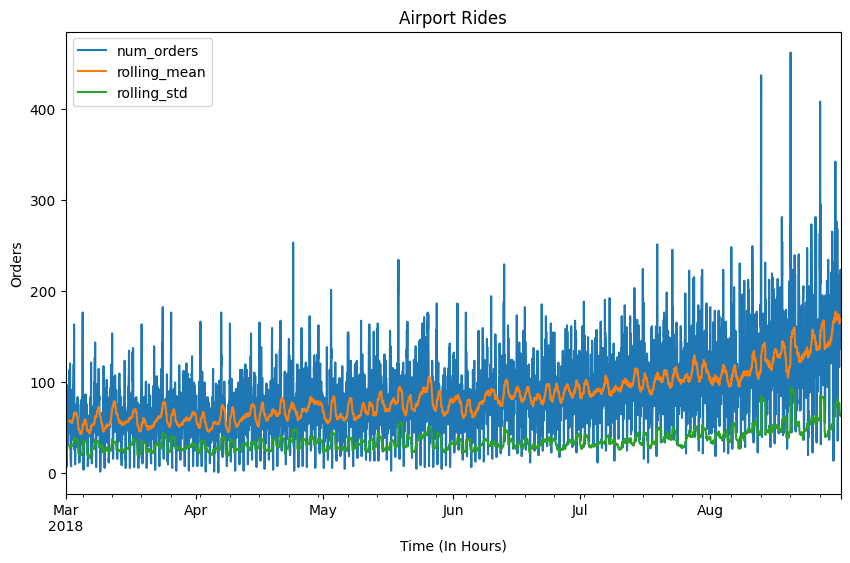

In [5]:
plt.figure(figsize=(10,6))

rolling = data.copy()
rolling['rolling_mean'] = data['num_orders'].rolling(24).mean()
rolling['rolling_std'] = data['num_orders'].rolling(24).std()

rolling.plot(ax=plt.gca())
plt.ylabel('Orders')
plt.xlabel('Time (In Hours)')
plt.title('Airport Rides')
plt.show()

The data seems random but the rolling mean indicates an overall upward trend and seem to indicate seasonality.

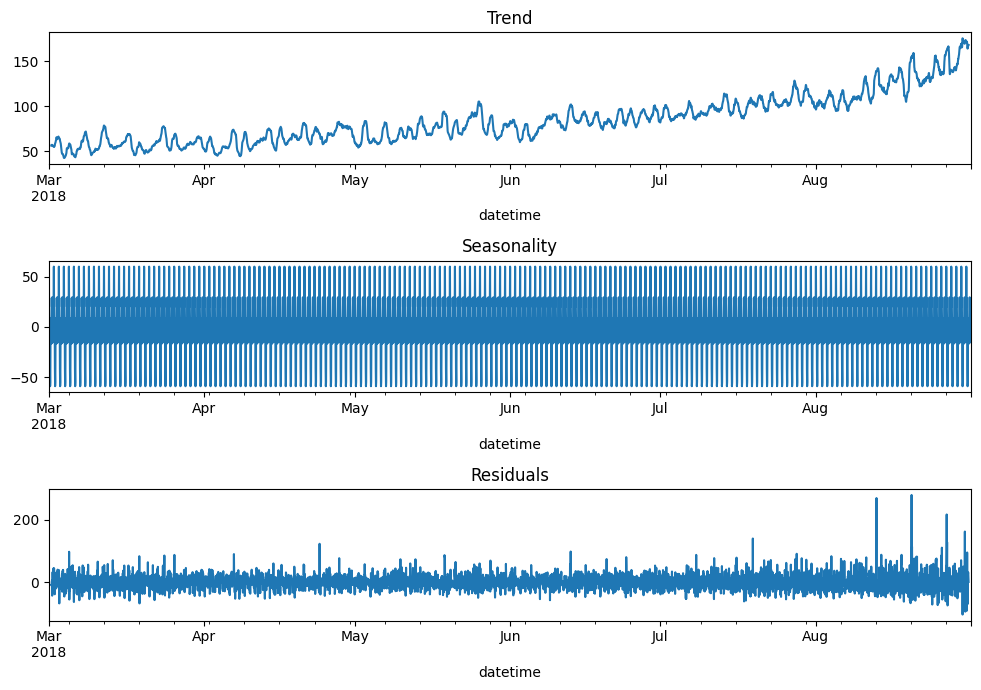

In [6]:
decomposed_data = seasonal_decompose(data)
plt.figure(figsize=(10,7))

plt.subplot(311)
decomposed_data.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed_data.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed_data.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()
plt.show()

Decomposing the data has shown what the rolling mean hinted at; the data trends upward and there is a relatively short seasonality to the data.

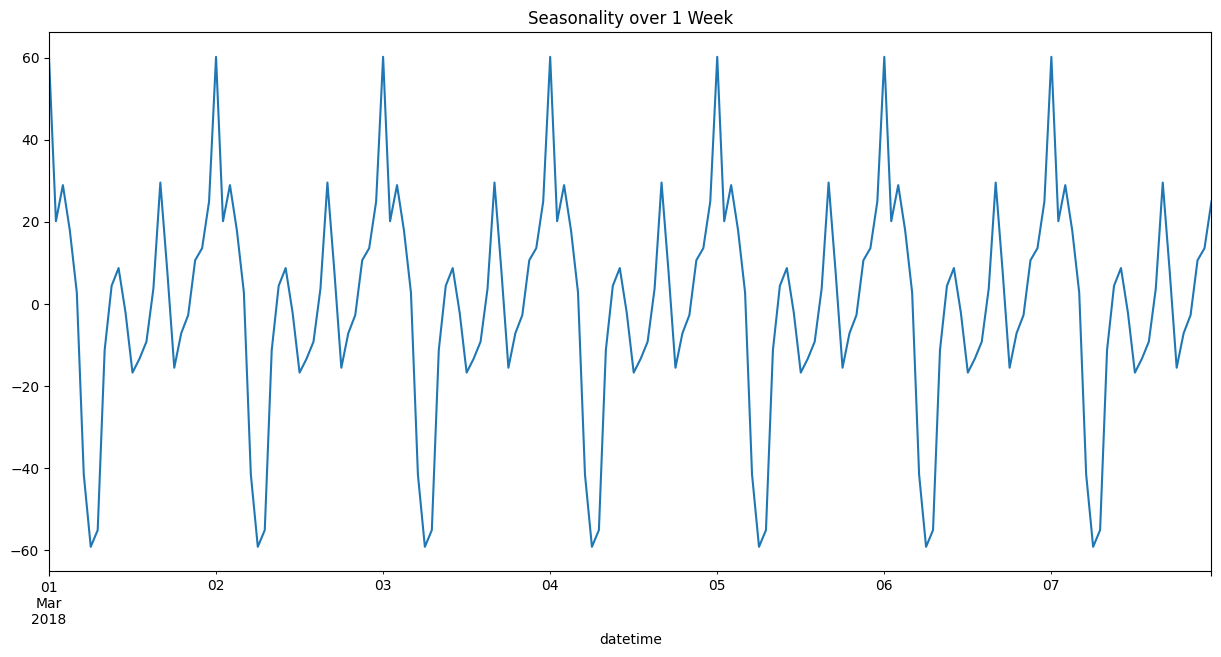

In [7]:
seasonal = decomposed_data.seasonal['2018-03-01':'2018-03-07']

plt.figure(figsize=(15,7))
seasonal.plot(ax=plt.gca())
plt.title('Seasonality over 1 Week')
plt.show()

This graph more clearly indicates that the optimal seasonality will be the 24 hour day.

## Training

The `make_features` function will be applied and then the data split at a test ratio of 10%

In [8]:
make_features(data, 4, [24])
data = data.fillna(0)
train, test = train_test_split(data, shuffle=False, test_size=0.1)
print(train.shape)
print(test.shape)
display(train.head())
display(test.head())

(3974, 10)
(442, 10)


,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,rolling_mean_24
datetime,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,0.0,0.0,0.0,0.0,0.0
2018-03-01 01:00:00,85,3,1,3,1,124.0,0.0,0.0,0.0,0.0
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,0.0,0.0,0.0
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,0.0,0.0
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,0.0


,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,rolling_mean_24
datetime,,,,,,,,,,
2018-08-13 14:00:00,102,8,13,0,14,119.0,92.0,144.0,156.0,138.541667
2018-08-13 15:00:00,175,8,13,0,15,102.0,119.0,92.0,144.0,138.458333
2018-08-13 16:00:00,144,8,13,0,16,175.0,102.0,119.0,92.0,139.541667
2018-08-13 17:00:00,152,8,13,0,17,144.0,175.0,102.0,119.0,139.166667
2018-08-13 18:00:00,104,8,13,0,18,152.0,144.0,175.0,102.0,140.708333


In [9]:
X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, sep='\n')

(3974, 9)
(3974,)
(442, 9)
(442,)


Now the data is ready to train the models:

In [10]:
# Initializing cross_validator
cross_validator = TimeSeriesSplit(n_splits=5)

# Creating LinearRegression param grid
line_params = {
    'n_jobs':[-1]
}

# Initializing LinearRegression and its GridSearchCV
linreg = LinearRegression()
line_grid = GridSearchCV(linreg, param_grid=line_params, scoring='neg_root_mean_squared_error', cv=cross_validator)
line_grid.fit(X_train, y_train)

print(line_grid.best_estimator_, '\n')
print(f'RMSE for Linear Regression model: {-line_grid.best_score_:.3f}')

LinearRegression(n_jobs=-1) 

RMSE for Linear Regression model: 31.385


In [11]:
# Creating DecisionTree param grid
tree_params = {
    'max_depth':[depth for depth in range(1,16)]
}

# Initializing DecisionTree and its GridSearchCV
tree_model = DecisionTreeRegressor(random_state=17)
tree_grid = GridSearchCV(tree_model, param_grid=tree_params, scoring='neg_root_mean_squared_error', cv=cross_validator)
tree_grid.fit(X_train, y_train)

print(tree_grid.best_estimator_, '\n')
print(f'Best Decision Tree RMSE: {-tree_grid.best_score_:.3f}')

DecisionTreeRegressor(max_depth=6, random_state=17) 

Best Decision Tree RMSE: 28.761


In [12]:
# Creating RandomForest param grid
forest_params = {
    'max_depth':[depth for depth in range(5, 25, 5)],
    'n_estimators':[n for n in range(20, 200, 20)],
    'min_samples_leaf':[2, 4]
}

# Initializing RandomForest and its GridSearchCV
forest_model = RandomForestRegressor(random_state=17)
forest_grid = GridSearchCV(forest_model, param_grid=forest_params, scoring='neg_root_mean_squared_error', cv=cross_validator)
forest_grid.fit(X_train, y_train)

print(forest_grid.best_estimator_, '\n')
print(f'Best Decision Tree RMSE: {-forest_grid.best_score_:.3f}')

RandomForestRegressor(max_depth=20, min_samples_leaf=2, random_state=17) 

Best Decision Tree RMSE: 25.007


In [13]:
best_order = auto_arima(y=y_train, trace=True, seasonal=True, suppress_warnings=True)
arima_params = best_order.get_params()
for key, value in arima_params.items():
    print(f"{key}: {value}")

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=9.81 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=39785.522, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=39407.923, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=39248.315, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=39783.522, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.57 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=3.60 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=5.30 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=39246.314, Time=0.29 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.60 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=1.53 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=39405.923, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=1.58 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 25.113 seconds
maxiter: 50
method: lbfgs
order: (0, 1, 1)
out_of_

In [14]:
arima_model = ARIMA(y_train, exog=X_train, order=arima_params['order'])
arima_model = arima_model.fit()
arima_model.summary()

/opt/conda/envs/python3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             num_orders   No. Observations:                 3974
Model:                 ARIMA(0, 1, 1)   Log Likelihood              -19349.741
Date:                Fri, 13 Sep 2024   AIC                          38721.482
Time:                        16:01:38   BIC                          38790.642
Sample:                    03-01-2018   HQIC                         38746.006
                         - 08-13-2018                                         
Covariance Type:                  opg                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
month             -67.5210    423.248     -0.160      0.873    -897.072     762.030
day                -1.6394     13.846     -0.118      0.906     -28.777      25.499
dayofweek          -1.9807      0.911     -2.174      0.030      -3.766      -0.195
hour               -2.0132      0.584     -3.445      0.001      -3.159      -0.868
lag_1              -0.5656      0.033    -16.934      0.000      -0.631      -0.500
lag_2              -0.2735      0.019    -14.046      0.000      -0.312      -0.235
lag_3              -0.2385      0.017    -14.219      0.000      -0.271      -0.206
lag_4              -0.1608      0.013    -12.102      0.000      -0.187      -0.135
rolling_mean_24    -4.2345      0.090    -47.186      0.000      -4.410      -4.059
ma.L1               0.2599      0.034      7.613      0.000       0.193       0.327
sigma2            995.6110     17.878     55.689      0.000     960.570    1030.651
===================================================================================
Ljung-Box (L1) (Q):                   0.53   Jarque-Bera (JB):               535.36
Prob(Q):                              0.47   Prob(JB):                         0.00
Heteroskedasticity (H):               1.65   Skew:                             0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Testing

**Sanity Check:**

In order to ensure models preform better than random chance, 2 sanity checks will be preformed:

1. All values of the test sample are predicted with the same number (a constant).
2. The new value x(t) is predicted by the previous value in the series, defined as x(t-1).

In [15]:
pred_mean = np.ones(test.shape) * train['num_orders'].mean()
print('Constant Sanity RMSE:', mean_squared_error(test, pred_mean) ** 0.5)

pred_previous = test.shift()
pred_previous.iloc[0] = train.iloc[-1]
print('Shift Sanity RMSE:', mean_squared_error(test, pred_previous) ** 0.5)

Constant Sanity RMSE: 76.04321743365394
Shift Sanity RMSE: 41.645746987280496


In [16]:
line_test = line_grid.predict(X_test)
line_test_score = mean_squared_error(y_test, line_test) ** 0.5
f'RMSE: {line_test_score}'

'RMSE: 51.650031992393345'

In [17]:
tree_test = tree_grid.predict(X_test)
tree_test_score = mean_squared_error(y_test, tree_test) ** 0.5
f'RMSE: {tree_test_score}'

'RMSE: 52.16186036260719'

In [18]:
forest_test = forest_grid.predict(X_test)
forest_test_score = mean_squared_error(y_test, forest_test) ** 0.5
f'RMSE: {forest_test_score}'

'RMSE: 46.618204579991634'

In [19]:
arima_test = arima_model.predict(start=len(train), end=len(train) + len(test) - 1, exog=X_test)
arima_test_score = mean_squared_error(y_test, arima_test) ** 0.5
f'RMSE: {arima_test_score}'

'RMSE: 146.7579642785815'

The Random Forest Model achieved an RMSE of 46.618 with the test data. The other models all scored over 50 with ARIMA scoring a measily 146.758.

# Review checklist

- [x]  Jupyter Notebook is open
- [x]  The code is error-free
- [x]  The cells with the code have been arranged in order of execution
- [x]  The data has been downloaded and prepared
- [x]  The data has been analyzed
- [x]  The model has been trained and hyperparameters have been selected
- [x]  The models have been evaluated. Conclusion has been provided
- [x] *RMSE* for the test set is not more than 48